In [163]:
#!pip install dtaidistance

In [164]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from sklearn.metrics import jaccard_score

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


In [4]:
#process the fcd data
path = "G:/My Drive/2021/Bias/sumo_simulation/"
os.chdir(path)
#os.listdir()

In [5]:
raw_dt_path = []
for i in os.listdir():
    if len(i) == 12 and '2017' in i:
        raw_dt_path.append(i)
print(raw_dt_path)

['20170404.csv', '20170411.csv', '20170406.csv', '20170405.csv', '20170413.csv', '20170412.csv', '20170420.csv', '20170419.csv', '20170418.csv', '20170427.csv', '20170426.csv', '20170425.csv']


In [12]:
#read_csv
def get_data(raw_path):
    idx = 0
    for path in raw_path:
        if idx == 0:
            dt = pd.read_csv(path)
            idx = 1
        else:
            dt_cur = pd.read_csv(path)
            dt = pd.concat([dt, dt_cur])
            
    get_hr = lambda x: int(x.split(':')[0])
    get_min = lambda x: int(x.split(':')[1])
    dt['hr'] = dt['time'].apply(get_hr)
    dt['min'] = dt['time'].apply(get_min)
    return(dt)



In [ ]:
dt = get_data(raw_dt_path)

(array([32747.,  4923.,  2527.,  2008.,  1777.,  1412.,  1311.,  1292.,
         1045.,  2516.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

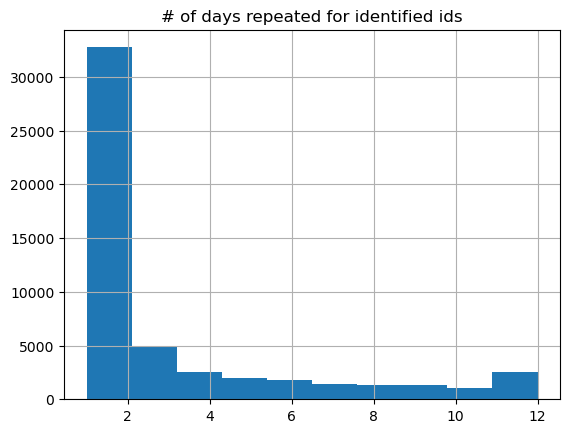

In [52]:
print('# of days', len(np.unique(dt['date'])))

dt_day = dt.groupby(by=['newid', 'date']).size().to_frame()
dt_day.reset_index(inplace=True)

dt_day.groupby(by=['newid', 'date']).size().to_frame()
dt_day.reset_index(inplace=True)

dt_day = dt_day[['newid', 'date', 0]]
dt_day = dt_day.groupby(by=['newid']).size().to_frame()
dt_day.reset_index(inplace=True)

plt.title('# of days repeated for identified ids')
plt.grid()
plt.hist(dt_day[0])

ids_with12 = dt_day['newid'][dt_day[0]==12].values

In [ ]:
dt_all = dt[dt['newid'].isin(ids_with12)]

In [118]:
#x_range = np.array(range(288))
newids = ids_with12[2]
def plot_num_obs(newids, plotidx):
    dt_newid = dt_all[dt_all['newid']==newids].sort_values(by=['date','hr','min'])
    dt_newid['time_idx'] = (dt_newid['hr']*12+dt_newid['min']/5).astype(int)
    dt_newid = dt_newid.groupby(by=['date','time_idx']).size().unstack(fill_value=0).stack().to_frame()
    dt_newid.reset_index(inplace=True)
    dt_newid = dt_newid.to_numpy().T

    for i in np.unique(dt_newid[0, ]):
        plt.figure(plotidx)
        time_ =  dt_newid[1, np.where(dt_newid[0,]==i)[0]]
        count_ = dt_newid[2, np.where(dt_newid[0,]==i)[0]]
        plt.plot(time_, count_, '.',label = 'date:'+str(i))
        plt.ylabel('# of obs')
        plt.xlabel('time idx')
    
    plt.legend()
    plt.grid()

In [117]:
np.where(dt_newid[0,]==4)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87], dtype=int64)

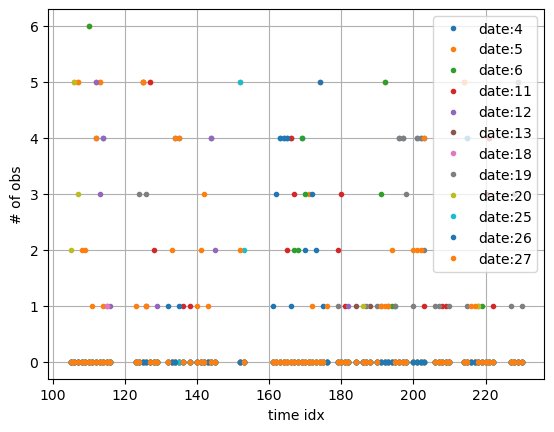

In [109]:
plot_num_obs(ids_with12[2], 0)

In [111]:
dt_all

,newid,sum,key,taz,date,time,hr,min
4,32,1,4_11_35_502,502,4,11:35,11,35
5,32,1,4_12_10_502,502,4,12:10,12,10
6,32,1,4_6_55_502,502,4,6:55,6,55
7,32,1,4_15_20_521,521,4,15:20,15,20
8,32,1,4_15_5_501,501,4,15:05,15,5
...,...,...,...,...,...,...,...,...
197339,458380,5,25_16_10_632,632,25,16:10,16,10
197340,458380,1,25_16_5_508,508,25,16:05,16,5
197341,458380,4,25_16_5_610,610,25,16:05,16,5
197342,458380,3,25_16_10_653,653,25,16:10,16,10


In [123]:
a = np.ones((3, 2))
b = np.zeros((2, 2))
np.vstack((a,b))

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.]])

In [273]:
def get_taz_dict(taz_val):
    idx = 0
    taz_dict = {}
    for i in taz_val:
        if i not in taz_dict:
            taz_dict[i] = idx
            idx += 1
    return(taz_dict)

def convert2matrix(newids, dt_all, binary_idx=False):
    dt_newid = dt_all[dt_all['newid']==32].sort_values(by=['date','hr','min'])
    taz =  np.unique(dt_newid['taz'])
    taz_dict = get_taz_dict(taz)
    get_taz_idx = lambda x: taz_dict[x]

    dt_newid['taz_idx'] = dt_newid['taz'].apply(get_taz_idx)
    dt_newid['time_idx'] = (dt_newid['hr']*12+dt_newid['min']/5).astype(int)

    #x_range = np.array(range(time_interval))
    time = np.unique(dt_newid['time_idx'])
    time_dict = get_taz_dict(time)
    get_time_idx = lambda x: time_dict[x]
    dt_newid['time_idx_r'] = dt_newid['time_idx'].apply(get_time_idx)

    #print(dt_newid.columns)
    dt_newid = dt_newid[['date','taz_idx','time_idx_r','sum']]
    dt_newid = dt_newid.to_numpy().T
    idx = 0

    arr = np.zeros((len(taz), len(time)))

    for i in np.unique(dt_newid[0,:]):
        arr_idx = np.where(dt_newid[0,]==i)[0]
        taz_idx = dt_newid[1, :][arr_idx] 
        time_idx = dt_newid[2, :][arr_idx] 
        sum_idx = dt_newid[3, :][arr_idx] 

        if binary_idx ==True:
            if idx == 0:
                arr[taz_idx, time_idx] = 1
                idx += 1
            else:
                arr_cur = np.zeros((len(taz), len(time)))
                arr_cur[taz_idx, time_idx] = 1
                arr = np.vstack((arr, arr_cur))
        else:
            if idx == 0:
                arr[taz_idx, time_idx] = sum_idx
                #print(arr.shape)
                idx += 1
            else:
                arr_cur = np.zeros((len(taz), len(time)))
                #print(arr_cur.shape)
                arr_cur[taz_idx, time_idx] = sum_idx
                arr = np.vstack((arr, arr_cur))
    return(arr)

#dtw
#https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html
def get_dtw_dist(a, b):
    return(dtw.distance_fast(a, b, use_pruning=True))
#path = dtw.warping_path(test[0].flatten(), test[1].flatten())
#dtwvis.plot_warping(test[0].flatten(), test[1].flatten(), path)

#cosine similarity
#https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/
def get_cos_sim(a, b):
    cosine_similarity = np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return(cosine_similarity)

#euclidean distance
def get_euc_dist(a, b):
    euclidean_distance = np.sqrt(np.sum((a - b) ** 2))
    return(euclidean_distance)

#pearson correlation
def get_pearson_cor(a, b):
    pearson_corr = np.corrcoef(a,b)[0, 1]
    return(pearson_corr)

#jaccard distance
def get_jacr_score(a, b):
    a, b = np.ravel(a), np.ravel(b)
    return(jaccard_score(a, b))

#hamming distance
def get_ham_dist(a, b):
    return(np.sum(a!= b))

### matrix similarity
Cosine similarity: This method measures the cosine of the angle between two vectors. To calculate the cosine similarity between two matrices, the matrices are first flattened into vectors, and then the cosine similarity between the two vectors is calculated.

Euclidean distance: This method calculates the distance between two matrices as the square root of the sum of the squared differences between the corresponding elements in the two matrices.

Pearson correlation coefficient: This method measures the linear correlation between two matrices. It is calculated as the covariance between the two matrices divided by the product of their standard deviations.

Jaccard similarity: This method calculates the similarity between two matrices by measuring the proportion of shared elements in the two matrices relative to the total number of unique elements in the two matrices.

Hamming distance: This method calculates the number of elements that differ between two matrices. It is often used for binary matrices.

These are just a few examples of the methods available to calculate matrix similarity. The choice of method depends on the nature of the matrices and the application.

In [217]:
test, num_taz = convert2matrix(32, dt_all, binary_idx=False)

In [258]:
test01, num_taz = convert2matrix(32, dt_all, True)

In [265]:
del(test, test01)

In [230]:
a, b = test[0].flatten(), test[1].flatten()

In [270]:
def get_dist_sim(newids, dt_all, num_days):
    obs = convert2matrix(newids, dt_all, False)
    obs01 = convert2matrix(newids, dt_all, True)
    
    obs = np.array_split(obs, num_days)
    obs01 = np.array_split(obs01, num_days)
    
    dist_dict = {'dtw':[],
                'cos_sim':[],
                'euc_dist':[],
                'pear_cor':[],
                'jac_s':[],
                'ham_dist':[]}
    
    for i in range(num_days):
        if i == 0:
            a = obs[i].flatten()
            a01 = obs01[i].flatten()
        else:
            b = obs[i].flatten()
            b01 = obs01[i].flatten()
            dist_dict['dtw'].append(get_dtw_dist(a, b))
            dist_dict['cos_sim'].append(get_cos_sim(a, b))
            dist_dict['euc_dist'].append(get_euc_dist(a, b))
            dist_dict['pear_cor'].append(get_pearson_cor(a, b))
            dist_dict['jac_s'].append(get_jacr_score(a01, b01))
            dist_dict['ham_dist'].append(get_ham_dist(a01, b01))
    
    return(dist_dict)

In [274]:
get_dist_sim(32, dt_all, 12)

{'dtw': [3.1622776601683795,
  3.1622776601683795,
  5.196152422706632,
  4.358898943540674,
  3.3166247903554,
  4.242640687119285,
  4.58257569495584,
  5.656854249492381,
  2.8284271247461903,
  3.7416573867739413,
  4.123105625617661],
 'cos_sim': [0.2561358820277077,
  0.18581403127845014,
  0.3310610959858653,
  0.43962048609243937,
  0.30969005213075024,
  0.22935415401872888,
  0.3132057248629988,
  0.24729786709407453,
  0.10425720702853737,
  0.41123916041498715,
  0.2786391062876764],
 'euc_dist': [8.717797887081348,
  8.888194417315589,
  9.899494936611665,
  8.602325267042627,
  8.18535277187245,
  9.9498743710662,
  9.38083151964686,
  10.246950765959598,
  8.366600265340756,
  8.246211251235321,
  8.888194417315589],
 'pear_cor': [0.2466112698127534,
  0.17658362357963883,
  0.3214777717547349,
  0.4323493712152249,
  0.30252820226652705,
  0.2192458415101254,
  0.3045513461183188,
  0.2369576505574754,
  0.09664384795099387,
  0.40354948088380177,
  0.27005458228406665]